# Service Team Routing
## Capacitated Vehicle Routing Problem with Time Windows (CVRPTW)

The ability of service providers to set service time windows allows for easier and more dependable coordination between the service provider and their customers, while increasing overall customer satisfaction.

In this scenario we have a number of service order locations with associated time windows and service times (time on-site to complete service). Each technician has an associated availability, ability to complete certain types of service, and a maximum number of service appointments per day.

### Problem Details:
- 8 Locations each with an associated demand
    - 1 Headquarters 
        - service type 1 demand: [0]
        - service type 2 demand: [1]
        - headquarters hours of operation: [5,20]
    - 7 Service Locations
        - service type 1 demand: [1, 1, 1, 0, 0, 0, 0]
        - service type 2 demand: [0, 0, 1, 1, 1, 1, 1]
        - service locations time windows: [[9,12],[9,12],[11,14],[13,16],[13,16],[13,16],[13,16]]
        - service location service times: [ 1, 1, 1.5, 0.5, 0.5, 0.5]

- 3 Delivery vehicles each with an associated capacity
    - 3 service technicians
        - capacity for service type 1: [2, 1, 0]
        - capacity for service type 2: [0, 1, 4]
        - technician availability [[9,17], [12,15], [9,17]]
        

Below we visualize the service locations with respect to the service company headquarters. The cost from all locations to all other locations (a cost matrix) will be required for optimization. To see an example of cost matrix generation from map data or a waypoint graph, refer to the [cost_matrix_and_waypoint_graph_creation.ipynb](../intra-factory_transport/cost_matrix_and_waypoint_graph_creation.ipynb) notebook.  For the purpose of this simple example we will omit the cost matrix calculation.

### Environment Setup
First, let's check if we have a GPU available in this Colab environment.

In [ ]:
# Check for GPUs
!nvidia-smi

#### Install dependencies


In [ ]:
# Install cuOpt

# Enable this in case you are running this in google colab or such places where cuOpt is not yet installed

# This would be incase underlying system is cuda-10.X 
# !pip install --user cuopt-cu11==25.5.* 

# This would be incase underlying system is cuda-12.x
# !pip install --user cuopt-cu12==25.5.*

In [ ]:
!pip install --user -q matplotlib scipy 

In [6]:
import os
import pandas as pd
import numpy as np
import cudf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from cuopt.routing import DataModel, SolverSettings, Solve

#### Utility functions


In [7]:
# Used to plot the Co-ordinates
def gen_plot(df):
    """
    Generate a plot with the locations.
    
    Args:
        df: DataFrame with location coordinates (xcord, ycord)
        
    Returns:
        matplotlib plot object
    """
    plt.figure(figsize=(11, 11))
    
    # Plot depot (first location)
    plt.scatter(
        df["xcord"][:1],
        df["ycord"][:1],
        label="Depot",
        color="Green",
        marker="o",
        s=100,
    )
    
    # Plot other locations
    plt.scatter(
        df["xcord"][1:],
        df["ycord"][1:],
        label="Locations",
        color="Red",
        marker="o",
        s=100,
    )
    
    plt.xlabel("x - axis")
    plt.ylabel("y - axis")
    plt.title("Simplified Map")
    plt.legend()

    # Add location labels
    for i, label in enumerate(df.index.values):
        plt.annotate(
            label,
            (df["xcord"][i], df["ycord"][i]),
            fontproperties=fm.FontProperties(size=16),
        )
    
    return plt


# Used to plot arrows
def add_arrows(df, route, plt, color="green"):
    """
    Add directional arrows to the plot to represent a route.
    
    Args:
        df: DataFrame with location coordinates
        route: List of location indices representing the route
        plt: matplotlib plot object
        color: Color for the arrows
        
    Returns:
        matplotlib plot object with arrows added
    """
    prev_cord = ()
    for i, label in enumerate(route):
        if i > 0:
            arrow_props = dict(
                arrowstyle="simple, head_length=0.5, head_width=0.5, tail_width=0.15",
                connectionstyle="arc3",
                color=color,
                mutation_scale=20,
                ec="black",
            )
            plt.annotate(
                "",
                xy=(df["xcord"][label], df["ycord"][label]),
                xytext=prev_cord,
                arrowprops=arrow_props,
                label=f"vehicle-{i}",
            )
        prev_cord = df["xcord"][label], df["ycord"][label]

    return plt


# Convert the solver response to a pandas dataframe for mapping
def get_solution_df(solution):
    """
    Converts a solution object to a pandas DataFrame
    
    Args:
        solution: A cuOpt routing.Solution object
    
    Returns:
        pandas.DataFrame: Contains the route information
    """
    # Check if it's a new API solution object
    if hasattr(solution, 'get_route'):
        # New API solution object
        routes_df = solution.get_route()
        return routes_df.to_pandas() if hasattr(routes_df, 'to_pandas') else routes_df
    
    # Check if it's a dictionary with vehicle_data key (legacy API)
    if isinstance(solution, dict) and "vehicle_data" in solution:
        solution_dict = solution["vehicle_data"]
        df = {}
        df["route"] = []
        df["truck_id"] = []
        df["location"] = []
        types = []

        for vid, route in solution_dict.items():
            df["location"] = df["location"] + route["route"]
            df["truck_id"] = df["truck_id"] + [vid] * len(route["route"])
            if "type" in list(route.keys()):
                types = types + route["type"]
        if len(types) != 0:
            df["types"] = types
        df["route"] = df["location"]

        return pd.DataFrame(df)
    
    # If solution is already a DataFrame, return it directly
    if isinstance(solution, pd.DataFrame):
        return solution
        
    # If we reach here, we don't recognize the format
    raise TypeError("Unrecognized solution format. Must be a Solution object, a response dictionary, or a DataFrame.")


# Prints vehicle routes
def show_vehicle_routes(solution, locations):
    """
    Print the vehicle routes in a readable format.
    
    Args:
        solution: cuOpt routing.Solution object
        locations: List of location names corresponding to indices
    """
    # Get route DataFrame from solution
    routes_df = solution.get_route()
    
    # Convert to pandas if it's a cudf DataFrame
    if hasattr(routes_df, 'to_pandas'):
        routes_df = routes_df.to_pandas()
        
    # Display routes for each vehicle
    for v_id in routes_df['truck_id'].unique():
        vehicle_route = routes_df[routes_df['truck_id'] == v_id]
        route_locations = vehicle_route['route'].tolist()
        
        print(f"For vehicle {v_id} route is:")
        path_parts = [locations[loc] for loc in route_locations]
        route_str = " → ".join(path_parts)
        print(route_str)
        print()


# Map vehicle routes
def map_vehicle_routes(df, solution, colors):
    """
    Creates a plot visualizing vehicle routes.
    
    Args:
        df: DataFrame with location coordinates
        solution: cuOpt routing.Solution object
        colors: List of colors to use for different vehicles
    
    Returns:
        matplotlib plot object with routes visualized
    """
    # Initialize plot with locations
    plt = gen_plot(df)
    
    # Get routes from solution
    routes_df = solution.get_route()
    
    # Convert to pandas if it's a cudf DataFrame
    if hasattr(routes_df, 'to_pandas'):
        routes_df = routes_df.to_pandas()
        
    # Get unique vehicle IDs
    vehicle_ids = routes_df['truck_id'].unique()
    
    # Create a mapping from vehicle ID to color index
    vid_map = {vid: i % len(colors) for i, vid in enumerate(vehicle_ids)}
    
    # Draw routes for each vehicle
    for v_id in vehicle_ids:
        v_route = routes_df[routes_df['truck_id'] == v_id]
        route_locs = v_route['route'].tolist()
        plt = add_arrows(
            df, 
            route_locs,
            plt, 
            color=colors[vid_map[v_id]]
        )
    
    return plt

/tmp/ipykernel_3668592/122218289.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),


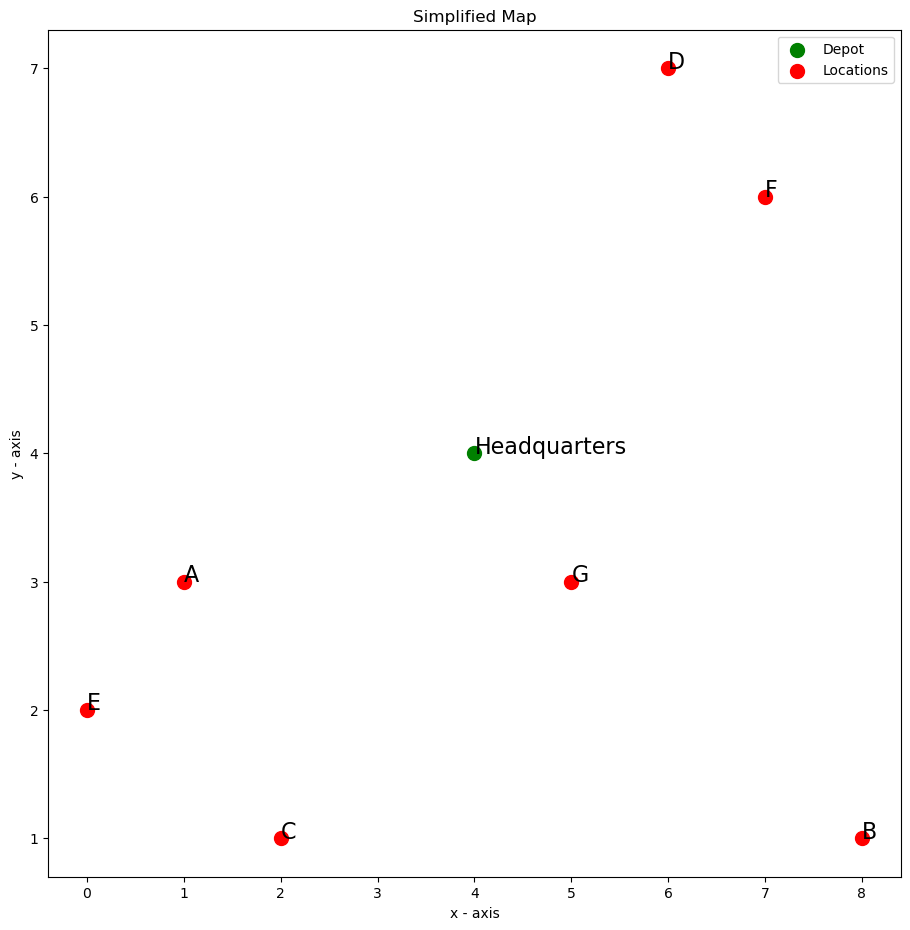

In [8]:
location_names       = [ "Headquarters",     "A",    "B",    "C",    "D",    "E",    "F",    "G"  ]
location_coordinates = [     [4, 4],        [1, 3], [8, 1], [2, 1], [6, 7], [0, 2], [7, 6], [5, 3] ]
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
gen_plot(location_coordinates_df).show()

### Cost Matrix

The cost matrix dictates the cost of travel between locations of interest.  The cost itself can be anything relevant to the user.  In this case we are constraining time window constraints.  When constraining time windows for locations or vehicles it is assumed (if only a single cost matrix is provided) that it represents time. 

Here is the cost(time) matrix corresponding to the locations above:

In [9]:
time_matrix = [
 [0.00, 0.31, 0.50, 0.36, 0.36, 0.44, 0.36, 0.14],
 [0.31, 0.00, 0.72, 0.22, 0.64, 0.14, 0.67, 0.40],
 [0.50, 0.72, 0.00, 0.60, 0.63, 0.80, 0.51, 0.36],
 [0.36, 0.22, 0.60, 0.00, 0.72, 0.22, 0.70, 0.36],
 [0.36, 0.64, 0.63, 0.72, 0.00, 0.77, 0.14, 0.41],
 [0.44, 0.14, 0.80, 0.22, 0.77, 0.00, 0.80, 0.51],
 [0.36, 0.67, 0.51, 0.70, 0.14, 0.80, 0.00, 0.36],
 [0.14, 0.40, 0.36, 0.36, 0.41, 0.51, 0.36, 0.00]
]

# Create a dataframe of this matrix
time_matrix_df  = pd.DataFrame(time_matrix, 
                              index=location_coordinates_df.index, 
                              columns=location_coordinates_df.index)
time_matrix_df

,Headquarters,A,B,C,D,E,F,G
Headquarters,0.00,0.31,0.50,0.36,0.36,0.44,0.36,0.14
A,0.31,0.00,0.72,0.22,0.64,0.14,0.67,0.40
B,0.50,0.72,0.00,0.60,0.63,0.80,0.51,0.36
C,0.36,0.22,0.60,0.00,0.72,0.22,0.70,0.36
D,0.36,0.64,0.63,0.72,0.00,0.77,0.14,0.41
E,0.44,0.14,0.80,0.22,0.77,0.00,0.80,0.51
F,0.36,0.67,0.51,0.70,0.14,0.80,0.00,0.36
G,0.14,0.40,0.36,0.36,0.41,0.51,0.36,0.00


### Service Locations

Setup the service location data

In [10]:
# exclude head quarters from service location names
service_location_ids = [1, 2, 3, 4, 5, 6, 7]
service_location_names = [location_names[i] for i in service_location_ids]
service_location_data = {
    "service_location_names": service_location_names,
    "service_location_ids": service_location_ids,
    "service_type1_demand": [1, 1, 1, 0, 0, 0, 0],
    "service_type2_demand": [0, 0, 1, 1, 1, 1, 1],
    "location_earliest_time": [9, 9, 11, 13, 13, 13, 13],
    "location_latest_time": [12, 12, 14, 16, 16, 16,16],
    "required_service_time": [1, 1, 1, 0, 0, 0, 0]
}
service_location_data_df = pd.DataFrame(service_location_data).set_index('service_location_names')
service_location_data_df

,service_location_ids,service_type1_demand,service_type2_demand,location_earliest_time,location_latest_time,required_service_time
service_location_names,,,,,,
A,1,1,0,9,12,1
B,2,1,0,9,12,1
C,3,1,1,11,14,1
D,4,0,1,13,16,0
E,5,0,1,13,16,0
F,6,0,1,13,16,0
G,7,0,1,13,16,0


### Vehicles

Setup vehicle/technician data

In [11]:
n_vehicles = 3
vehicle_data = {
    "vehicle_ids": [i for i in range(n_vehicles)],
    "capacity_service_type1":[2, 1, 0],
    "capacity_service_type2":[0, 1, 4],
    "vehicle_availability_earliest":[9, 11, 9],
    "vehicle_availability_latest":[17, 15, 17]
}
vehicle_data_df = pd.DataFrame(vehicle_data).set_index('vehicle_ids')
vehicle_data_df

,capacity_service_type1,capacity_service_type2,vehicle_availability_earliest,vehicle_availability_latest
vehicle_ids,,,,
0,2,0,9,17
1,1,1,11,15
2,0,4,9,17


# Initialize cuOpt Problem Data Using Python API

In [12]:
# Create DataModel
# Params: num_locations, num_vehicles, num_orders
n_locations = len(location_names)
n_orders = len(service_location_ids)
data_model = DataModel(n_locations, n_vehicles, n_orders)

### Set Cost Matrix

In [13]:
# Convert the time matrix to cuDF DataFrame
cost_matrix = cudf.DataFrame(time_matrix).astype(np.float32)
data_model.add_cost_matrix(cost_matrix)

### Set Order Locations and Properties

In [14]:
# Set order locations
data_model.set_order_locations(cudf.Series(service_location_ids))

# Set order time windows
order_earliest = cudf.Series(service_location_data["location_earliest_time"]).astype(np.int32)
order_latest = cudf.Series(service_location_data["location_latest_time"]).astype(np.int32)
data_model.set_order_time_windows(order_earliest, order_latest)

# Set order service times
service_times = cudf.Series(service_location_data["required_service_time"]).astype(np.int32)
data_model.set_order_service_times(service_times)

### Set Vehicle Data

In [15]:
# Set vehicle time windows
vehicle_earliest = cudf.Series(vehicle_data["vehicle_availability_earliest"]).astype(np.int32)
vehicle_latest = cudf.Series(vehicle_data["vehicle_availability_latest"]).astype(np.int32)
data_model.set_vehicle_time_windows(vehicle_earliest, vehicle_latest)

# Add capacity dimensions for service types
service_type1_demand = cudf.Series(service_location_data["service_type1_demand"]).astype(np.int32)
service_type1_capacity = cudf.Series(vehicle_data["capacity_service_type1"]).astype(np.int32)
data_model.add_capacity_dimension("service_type1", service_type1_demand, service_type1_capacity)

service_type2_demand = cudf.Series(service_location_data["service_type2_demand"]).astype(np.int32)
service_type2_capacity = cudf.Series(vehicle_data["capacity_service_type2"]).astype(np.int32)
data_model.add_capacity_dimension("service_type2", service_type2_demand, service_type2_capacity)

### Set Solver Configuration

In [16]:
# Create solver settings
solver_settings = SolverSettings()
solver_settings.set_time_limit(5)

### Get Optimized Routes

In [18]:
# Solve the problem
solution = Solve(data_model, solver_settings)

if solution.get_status() == 0:  # Success
    print("Cost for the routing in distance: ", solution.get_total_objective())
    print("Vehicle count to complete routing: ", solution.get_vehicle_count())
    
    # Get routes
    routes = solution.get_route()
    
    # Display routes
    show_vehicle_routes(solution, location_names)
else:
    print("NVIDIA cuOpt Failed to find a solution with status : ", solution.get_status())

Cost for the routing in distance:  4.060000076889992
Vehicle count to complete routing:  3
For vehicle 0 route is:
Headquarters → Headquarters → A → Headquarters

For vehicle 2 route is:
Headquarters → C → E → F → D → Headquarters

For vehicle 1 route is:
Headquarters → B → Headquarters



**Notice** that this solution leverages the fact that vehicle 1 is the only vehicle with the ability to perform both service type 1 and service type 2.  In addition, vehicle 0 and vehicle 2 also serve the locations they are suited to service and minimize the time taken along these routes.

/tmp/ipykernel_3668592/122218289.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),
/tmp/ipykernel_3668592/122218289.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_cord = df["xcord"][label], df["ycord"][label]
/tmp/ipykernel_3668592/122218289.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(df["xcord"][label], df["ycord"][label]),


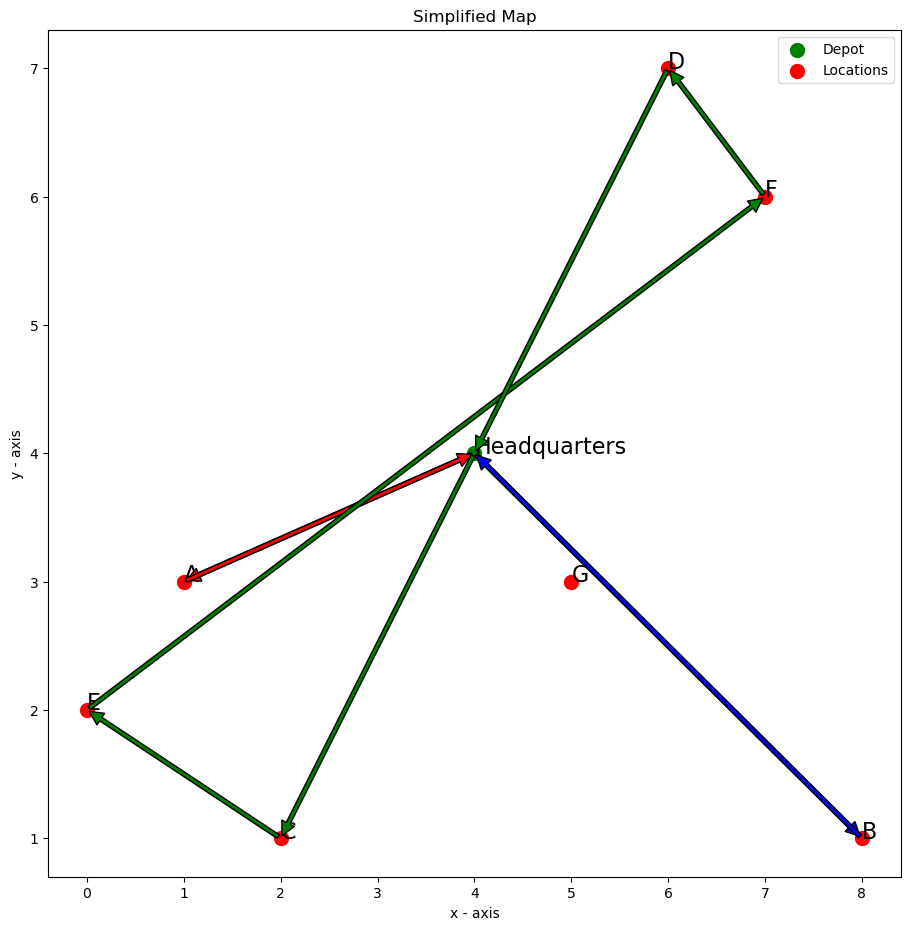

In [20]:
vehicle_colors = ["red", "green", "blue"]
map_vehicle_routes(location_coordinates_df, solution, vehicle_colors).show()


SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.